## Demonstrates that spectra generated in tensorflow and numpy are identical to those generated in the original python code

In [1]:
import math
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

Ranges of parameters in units and constants used in experiment.

In [2]:
sp_min, sp_max = -10., 10.
fr_min, fr_max = 0., 256.
dc_min, dc_max = 0.1, 10.
am_min, am_max = 0.1, 5.

series = 20
dwmin, dwmax = -10., 10.

Number of pixels along the speed and frequency dimension and random number of peaks from 1 to 9 and distributes them at random regardless of the YOLO grid.

In [3]:
sp_pixels, fr_pixels = 2000, 256
peaks = tf.random.uniform([], 1, 10, dtype = tf.int32)

## Spectrum generated in tensorflow

Random peak parameters in units used in experiment.

In [4]:
sp_values = tf.random.uniform([peaks], sp_min, sp_max)
fr_values = tf.random.uniform([peaks], fr_min, fr_max)
dc_values = tf.random.uniform([peaks], dc_min, dc_max)
am_values = tf.random.uniform([peaks], am_min, am_max)

Auxiliary arrays for generating spectrum in tensorflow.

In [5]:
t = tf.complex(tf.range(2 * fr_pixels, dtype = tf.float32) / fr_pixels / 2., 0.)
a = tf.range(series, dtype = tf.float32)
b = 2. * math.pi * \
    tf.complex(0., tf.range(dwmin, dwmax, (dwmax - dwmin) / sp_pixels, dtype = tf.float32))[:, None] * t

Generating and plotting spectrum.

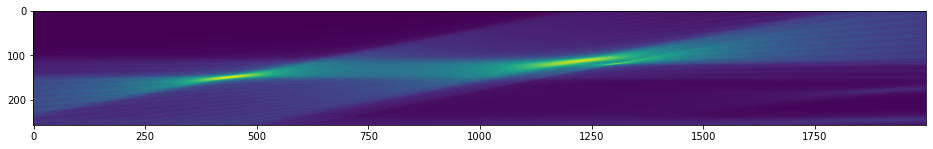

In [6]:
f = a[:, None] * sp_values + fr_values + fr_pixels / 2.
fid = tf.complex(am_values, 0.) * tf.exp(2. * math.pi * t[:, None, None] * (tf.complex(-dc_values, f))) * \
      tf.cast(tf.logical_and(0.8 * fr_pixels / 2. <= f, f <= 2. * fr_pixels - 0.8 * fr_pixels / 2.), tf.complex64)
fid = tf.reduce_sum(fid, 2) 
fid = tf.concat([fid[: 1] / 2., fid[1:]], 0)
p = tf.exp(-b[:, :, None] * tf.complex(a, 0.)) * fid
spectrum_tf = tf.math.real(tf.signal.fft(tf.reduce_sum(p, 2)))[:, fr_pixels // 2 : 2 * fr_pixels - fr_pixels // 2]

plt.figure(figsize=(16,10))
plt.imshow(tf.transpose(spectrum_tf))
plt.show()

## Spectrum generated in numpy

Peak parameters in units used in experiment.

In [7]:
sp_values = np.array(sp_values, np.float64)
fr_values = np.array(fr_values, np.float64)
dc_values = np.array(dc_values, np.float64)
am_values = np.array(am_values, np.float64)

Auxiliary arrays for generating spectrum in numpy.

In [8]:
t = np.arange(2 * fr_pixels) / fr_pixels / 2
a = np.arange(series)
b = 2 * np.pi * 1j * np.arange(dwmin, dwmax, (dwmax - dwmin) / sp_pixels)[:, None] * t

Generating and plotting spectrum.

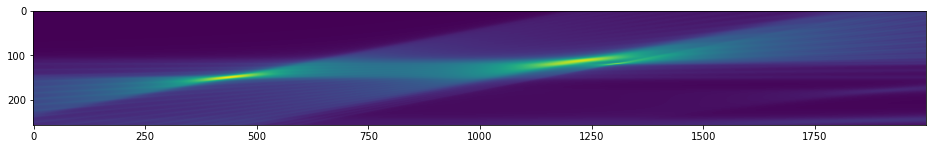

In [9]:
f = a[:, None] * sp_values + fr_values + fr_pixels / 2
fid = am_values * np.exp(2 * np.pi * t[:, None, None] * (1j * f - dc_values)) * \
      np.logical_and(0.8 * fr_pixels / 2 <= f, f <= 2 * fr_pixels - 0.8 * fr_pixels / 2)
fid = fid.sum(2)
fid[0] /= 2
p = np.exp(-b[:, :, None] * a) * fid
spectrum_np = np.fft.fft(p.sum(2))[:, fr_pixels // 2 : 2 * fr_pixels - fr_pixels // 2].real

plt.figure(figsize=(16,10))
plt.imshow(spectrum_np.T)
plt.show()

## Spectrum generated in original python code

Generating and plotting spectrum.

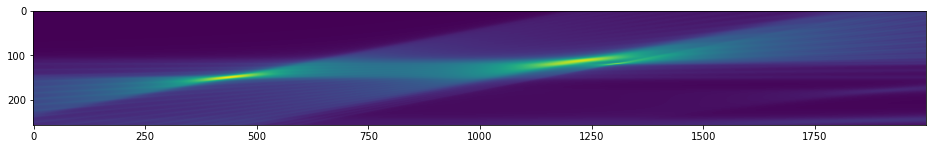

In [10]:
n2 = 2 * fr_pixels
freq_shift = int(fr_pixels / 2)
shifted_freq = [freq + freq_shift for freq in fr_values]
fid = np.zeros((series, n2), dtype = "complex128")
t = np.linspace(0, 1, n2, endpoint = False)
for i in range(series):
    for k in range(np.shape(am_values)[0]):
        tot_freq = shifted_freq[k] + i * sp_values[k]
        if (0.8 * freq_shift <= tot_freq <= n2 - 0.8 * freq_shift):
            exponent = (2 * np.pi * 1j * (tot_freq + 1j * dc_values[k]) * t)
            fid[i] = np.add(fid[i], am_values[k] * np.e ** exponent)
for i in range(series):
    fid[i][0] /= 2
dw_arr = np.linspace(dwmin, dwmax, sp_pixels, endpoint = False)
p = np.zeros((len(dw_arr), *np.shape(fid)), dtype = "complex128")
a = 2 * np.pi * 1j * np.linspace(0, 1, n2, endpoint = False)
for i in range(len(dw_arr)):
    b = a * dw_arr[i]
    for k in range(series):
        p[i][k] = fid[k] * np.e ** (-b * k)
pr = np.zeros((len(dw_arr), n2), dtype = "complex128")
for i in range(len(dw_arr)):
    for j in range(series):
        pr[i] += p[i][j]
spectrum_py = np.fft.fft(pr)[:, freq_shift : n2 - freq_shift].real

plt.figure(figsize=(16,10))
plt.imshow(spectrum_py.T)
plt.show()

## Compare of the generated spectra

Calculation of mean squared differences between spectra generated in tensorflow and original python code.

In [11]:
print("MSEtf-py: %.9f" % (np.square(spectrum_tf - spectrum_py).mean()))

MSEtf-py: 0.000285525


Calculation of mean squared differences between spectra generated in numpy and original python code.

In [12]:
print("MSEnp-py: %.21f" % (np.square(spectrum_np - spectrum_py).mean()))

MSEnp-py: 0.000000000000000000001
